# Imports

In [1]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [2]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import optuna
import utils.h5_utils as h5
import random

from pathlib import Path
from npyx.feat import filter_df
from sklearn import preprocessing
from tqdm.auto import tqdm, trange
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

npyx version 2.5.2 imported.


In [3]:
# get relative data folder
PATH = os.path.dirname(os.path.abspath(''))
data_folder = PATH + '/data'
DATA_PATH = data_folder + ("/Aug-09-2022_all_features.csv")


In [4]:
SEED = 1234
h5.set_seed(SEED)

Random seed 1234 has been set.


1234

In [5]:
df = pd.read_csv(DATA_PATH, index_col=0)

In [6]:
def filter_df(df:pd.DataFrame):
    """
    Filters out datapoints with unusable temporal features.
    """
    features_only = df.iloc[:, 2:]
    bad_idx = []
    for i, row in features_only.iterrows():
        value, count = np.unique(row.to_numpy(), return_counts=True)
        zeros = count[value == 0]
        if  zeros.size > 0 and zeros > 5:
            bad_idx.append(i)
    keep = [i for i in range(len(df)) if i not in bad_idx]
    return df.iloc[keep]

In [7]:
def generate_train_and_labels(df: pd.DataFrame, info_idx = [0, 1 , 2 ,18]):
    info = df.iloc[:, info_idx]
    features = df.iloc[:, ~np.isin(np.arange(len(df.columns)), info_idx)]
    return features.copy(), info.iloc[:, 0].copy()

In [8]:
discard_idx = [0, 1 , 2 ,18]+list(range(3, 18))
X, y = generate_train_and_labels(filter_df(df), info_idx = discard_idx)

In [9]:
X

,trough_voltage,trough_t,peak_voltage,peak_t,repolarisation_t,depolarisation_t,peak_50_width,trough_50_width,onset_t,onset_amp,wvf_width,peak_trough_ratio,recovery_slope,repolarisation_slope,depolarisation_slope,spatial_decay_24um,dendritic_comp_amp
0,-318.603741,4150,307.640664,4858,249,369,783,354,3696,-15.930187,708,0.965590,-0.110271,0.422205,-0.279495,224.472656,1.034460
1,-307.140140,4150,275.485816,4858,243,317,779,354,11,-15.357007,708,0.896938,-0.101313,0.390629,-0.259964,250.253906,0.825570
2,-164.509510,4150,159.654784,4758,219,440,788,374,3581,-8.225476,608,0.970490,-0.107239,0.446767,-0.189874,230.332031,0.900092
3,-391.026195,3543,467.397649,4150,230,280,758,439,3141,-19.551310,607,1.195310,-0.098358,0.340348,-0.111963,216.503906,0.730440
4,-320.123769,4150,277.216615,4859,263,235,760,348,22,-16.006188,709,0.865967,-0.096014,0.364638,-0.318373,597.480469,0.777856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,-125.948777,4150,54.371784,4758,188,234,1201,323,50,-6.297439,608,0.431698,-0.012354,0.393738,-0.280353,122.636719,5.888535
80,-79.130827,4151,44.111768,4758,181,312,1019,338,75,-3.956541,607,0.557454,-0.035949,0.337329,-0.381563,46.171875,1.627548
81,-72.331251,4150,29.178916,5365,423,169,929,316,3943,-3.616563,1215,0.403407,-0.038293,0.201941,-0.442478,68.261719,4.352540
82,-73.510522,4150,59.521795,4657,184,182,525,313,3904,-3.675526,507,0.809704,-0.112040,0.375486,-0.389621,85.839844,12.297384


In [10]:
# Converting text labels to numbers
LABELLING = {'PkC_cs': 5, 'PkC_ss': 4, 'MFB':3, 'MLI':2, 'GoC':1, 'GrC':0}

# To do the inverse
CORRESPONDENCE = {5: 'PkC_cs', 4: 'PkC_ss', 3 : 'MFB', 2: 'MLI', 1:'GoC', 0:'GrC'}

y.replace(to_replace = LABELLING, inplace = True)

In [11]:
y.value_counts()

1    25
4    21
5    11
3     9
0     6
2     5
Name: label, dtype: int64

# Random forest

In [12]:
best_params = optuna.load_study("random-forest-feat-eng", f"sqlite:///{PATH}/random-forest-feat-eng.db").best_params

In [13]:
N_LOOS = 50

In [14]:
kfold = LeaveOneOut()

f1_scores = []
confusions_list = []

for loo in tqdm(range(N_LOOS), position = 0, leave = True, desc = "Random Forest runs"):
    
    train_accuracies = []
    true_targets = []
    model_pred = []
    dummy_pred = []
    seed = np.random.choice(2**32)
    for fold, (train_idx, val_idx) in tqdm(
        enumerate(kfold.split(X, y)),
        leave=False,
        position=1,
        desc="Cross-validating",
        total=len(X),
    ):

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[val_idx]
        y_test = y.iloc[val_idx]

        oversample = RandomOverSampler(random_state=seed)

        X_big, y_big = oversample.fit_resample(X_train, y_train)

        model = RandomForestClassifier(**best_params, random_state=seed)

        # fit the model on the data
        model.fit(X_big, y_big)
        pred = model.predict(X_test)
        train_accuracies.append(model.score(X_train, y_train))

        true_targets.append(y_test)
        model_pred.append(pred)
        

        ####### Now doing something similar with a Dummy Classifier so that we can plot a baseline #########
        dummy = DummyClassifier(strategy="uniform")
        # fit the model on the data
        dummy.fit(X_big, y_big)
        pred = dummy.predict(X_test)

        dummy_pred.append(pred)
        
    confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
    confusions_list.append(confusion)
    f1 = f1_score(true_targets, model_pred, average='macro')
    f1_scores.append(f1)



mean_train = np.array(train_accuracies).mean()
mean_validation = (np.array(true_targets)==np.array(model_pred)).mean()
mean_dummy = (np.array(true_targets)==np.array(dummy_pred)).mean()
print(
f"Mean train accuracy is {mean_train:.3f} while LOO accuracy is {mean_validation:.3f}"
)
print(f"Dummy LOO accuracy is {mean_dummy:.3f} ")
print(f"Mean LOO f1 score across random forests is {np.array(f1_scores).mean():.3f}")


Random Forest runs:   0%|          | 0/50 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Mean train accuracy is 0.975 while LOO accuracy is 0.584
Dummy LOO accuracy is 0.182 
Mean LOO f1 score across random forests is 0.441


In [15]:
X.to_numpy().shape

(77, 17)

In [16]:
max(f1_scores)

0.5020185488270595

In [17]:
np.array(train_accuracies).std()

0.005988180269287484

In [19]:
np.array(f1_scores).std()

0.031853166977491056

# Accuracy plots

# Confusion matrix

In [20]:
mean_confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, len(LABELLING.keys())))
mean_confusion = mean_confusion / (np.sum(mean_confusion, axis = 0)) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

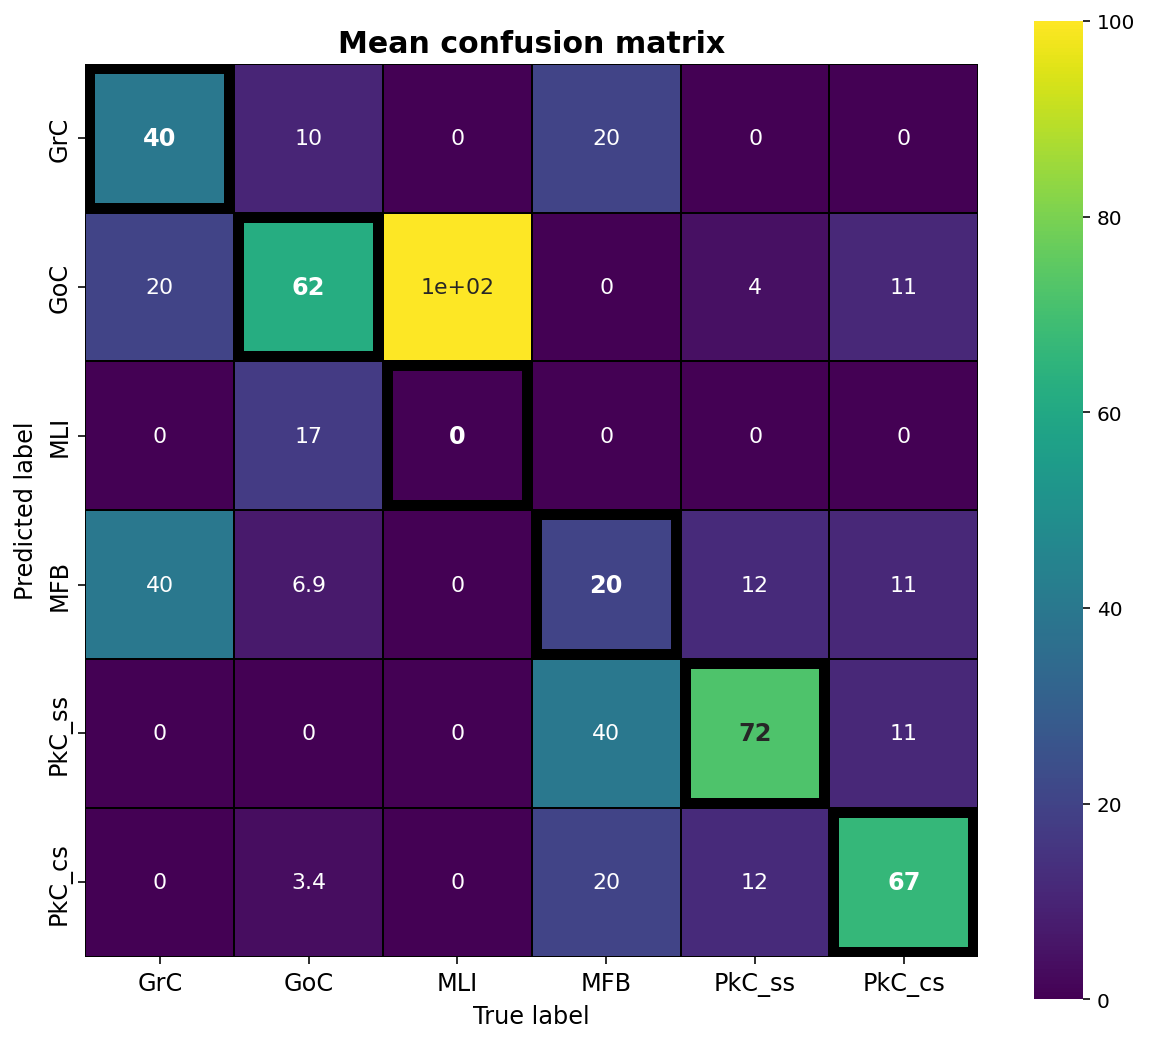

In [21]:
# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=False,
    mask=mask,
    linewidths=10,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    square=True,
    vmin=0,
    vmax=100,
    mask=~mask,
    linewidths=1,
    linecolor="black",
    annot_kws={"fontsize": 11},
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);
